In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
#di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
#di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

di.display_html('''
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
''')

# Sedov Blast: Bouchut5

This notebook describes the "Sedov" blast setup computed with the [FLASH 4.3](http://www.flash.uchicago.edu/site/flashcode).

Setup characteristics:

| term                 | symbol    | value               |
|:-------------------- |:---------:|:-------------------:|
| governing equations  |  --       | compressible Euler  |
| equation of state    |  --       |ideal gas (adiabatic)|
| ambient density      | $\rho_0$  | $1.0$               |
| ambient pressure     | $p_0$     | $10^{-5} \approx 0$ |
| adiabatic const.     | $\gamma$  | $1.4$               |
| initial blast energy | $E_0$     | $1.19025916404$     |
| CFD method           |   --      | Finite-Volume       |
| Riemann Flux         |   --      | Bouchut 5           |
| "FV-equiv." resolution | $N_r$   | 768 x 768           |

# Density and pressure heat maps

In [2]:
import sys
import os
home = os.environ['HOME']
sys.path.append(home + '/projects/turbubox/tools/lib')

import numpy as np
import pandas as pd
import glob
import cubicle

import matplotlib
matplotlib.rcParams.update({'font.size': 9})

import matplotlib.pyplot as plt
%matplotlib inline

gamma = 1.4

In [3]:
def mkplot(fh, gamma = 1.4):
        
    dens,velx,vely,velz,pres = [x[:,:,0] for x in fh.get_prims()]

    dpi = 100
    fig = plt.figure(1,figsize=(2*640/dpi, 480/dpi), dpi=dpi)

    plt.xlim(fh.domain.T[0,:])
    plt.ylim(fh.domain.T[1,:])

    extent = fh.domain.T.ravel()[0:4]
    
    plt.subplot(121)

    plt.title('density at time t = {:6.3f}'.format(fh.time))
    plt.imshow(
        dens,
        extent = extent,
        vmin = 0.0,
        #vmax = 7.5,
        origin='lower',
        interpolation = None,
        cmap = plt.get_cmap('cubehelix'),
    )
    plt.colorbar()

    plt.subplot(122)
    plt.title('pressure at time t = {:6.3f}'.format(fh.time))

    plt.imshow(
        pres,
        extent = extent,
        vmin = 0.0,
        #vmax = 7.5,
        origin='lower',
        interpolation = None,
        cmap = plt.get_cmap('cubehelix'),
    )
    plt.colorbar()

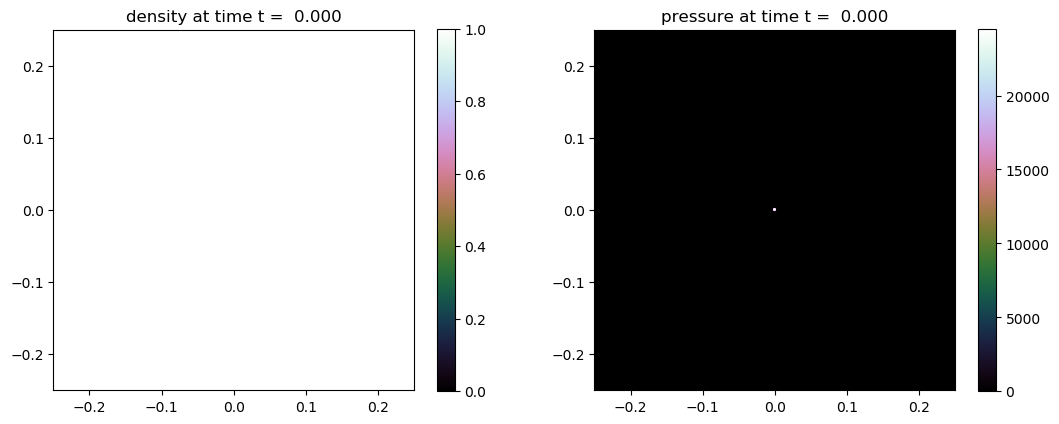

In [4]:
fp = '/mnt/sshfs/cheops/scratch/jmarker2/flash/sedov/run/sedov_hdf5_chk_0000'
fh = cubicle.File(fp)
mkplot(fh)

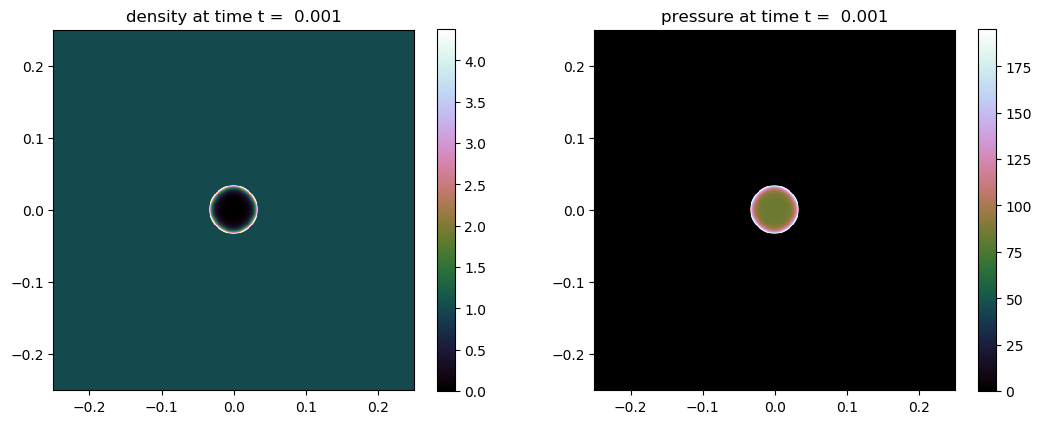

In [5]:
fp = '/mnt/sshfs/cheops/scratch/jmarker2/flash/sedov/run/sedov_hdf5_chk_0001'
fh = cubicle.File(fp)
mkplot(fh)

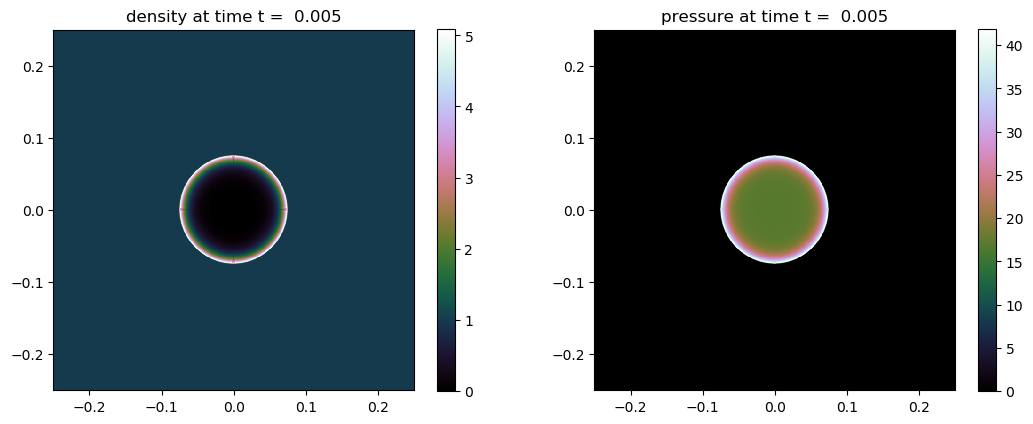

In [6]:
fp = '/mnt/sshfs/cheops/scratch/jmarker2/flash/sedov/run/sedov_hdf5_chk_0005'
fh = cubicle.File(fp)
mkplot(fh)

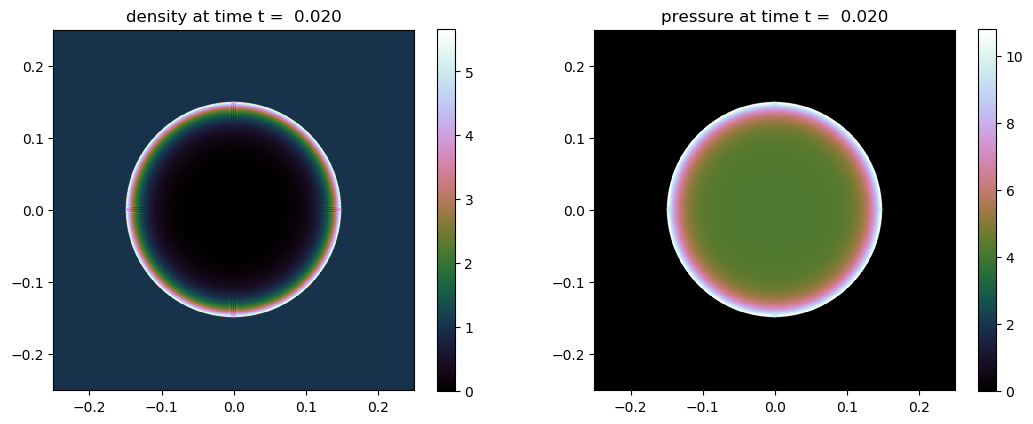

In [7]:
fp = '/mnt/sshfs/cheops/scratch/jmarker2/flash/sedov/run/sedov_hdf5_chk_0020'
fh = cubicle.File(fp)
mkplot(fh)

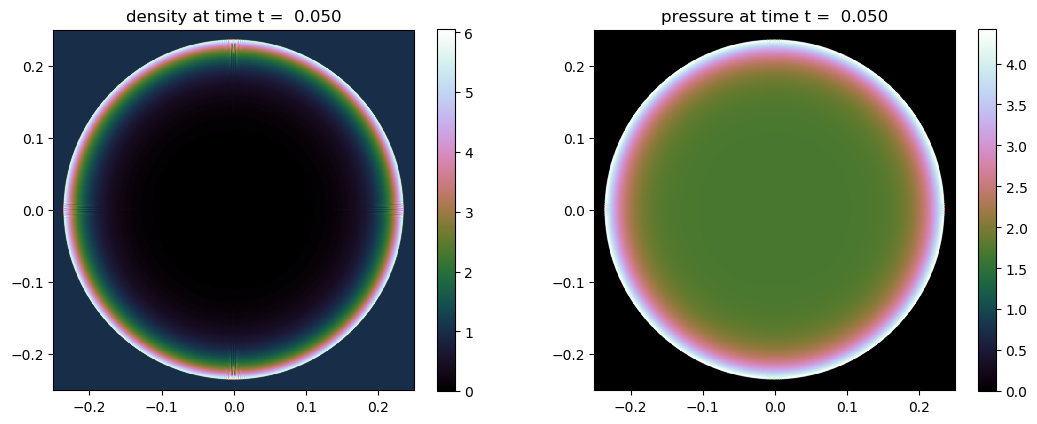

In [8]:
fp = '/mnt/sshfs/cheops/scratch/jmarker2/flash/sedov/run/sedov_hdf5_chk_0050'
fh = cubicle.File(fp)
mkplot(fh)

## Shell-averaged density and pressure profiles

In [9]:
mkpd_a = lambda fp: pd.read_table(fp, names='nr radius dens ener pres vels sndspd'.split(), sep='\s+')
dirp = '/mnt/sshfs/cheops/scratch/jmarker2/flash/sedov/shell-averages/analytic'
analytics = [mkpd_a(fp) for fp in glob.glob(dirp+'/analytical_*.dat')]

In [10]:
mkpd_d = lambda fp: pd.read_table(fp, names='radius dens'.split(), sep='\s+', skiprows=1)
mkpd_p = lambda fp: pd.read_table(fp, names='radius pres'.split(), sep='\s+', skiprows=1)

dirp = '/mnt/sshfs/cheops/scratch/jmarker2/flash/sedov/shell-averages/numeric'
dens = [mkpd_d(fp) for fp in glob.glob(dirp+'/density-*.dat')]
pres = [mkpd_p(fp) for fp in glob.glob(dirp+'/pressure-*.dat')]

numerics = [pd.concat((de,pr.pres),axis=1) for de,pr in zip(dens,pres)]

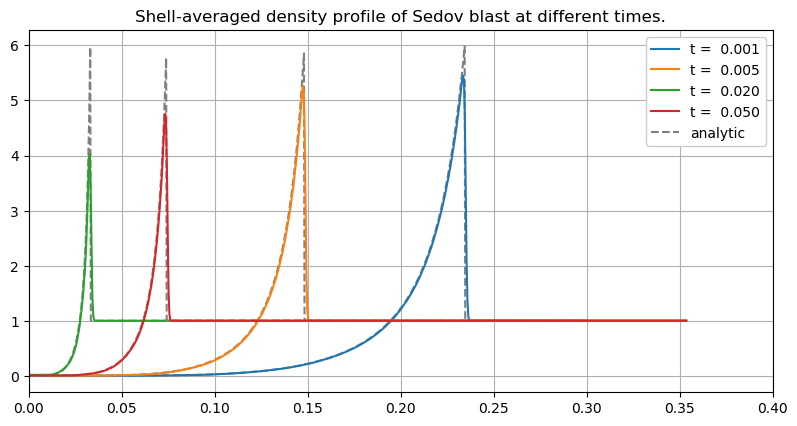

In [11]:
dpi = 100
fig = plt.figure(1,figsize=(1.5*640/dpi, 480/dpi), dpi=dpi)
plt.grid()
plt.xlim(0,0.4)
plt.title('Shell-averaged density profile of Sedov blast at different times.')

for ana,num,t in zip(analytics,numerics,[0.001,0.005,0.02,0.05]):
    plt.plot(ana.radius,ana.dens, label='_nolegend_', ls='--',color='gray')
    plt.plot(num.radius,num.dens, label='t = {:6.3f}'.format(t))

plt.plot([],[], label='analytic', ls='--',color='gray')
plt.legend().get_frame().set_alpha(1)

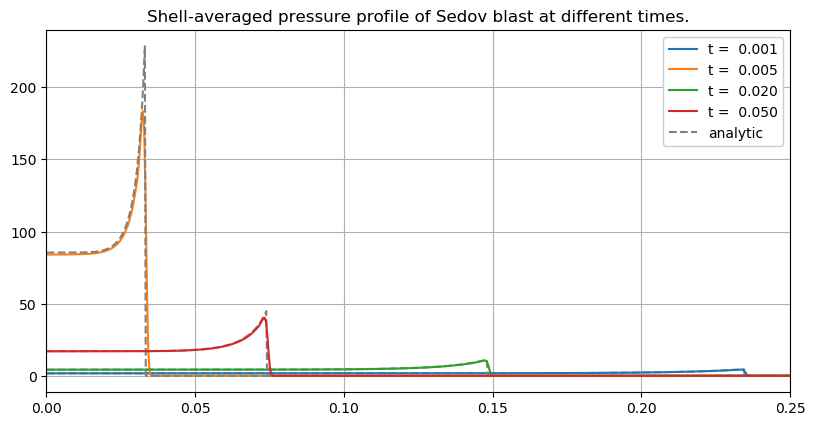

In [12]:
dpi = 100
fig = plt.figure(1,figsize=(1.5*640/dpi, 480/dpi), dpi=dpi)
plt.grid()
plt.xlim(0,0.25)
plt.title('Shell-averaged pressure profile of Sedov blast at different times.')

for ana,num,t in zip(analytics,numerics,[0.001,0.005,0.02,0.05]):
    plt.plot(ana.radius,ana.pres, label='_nolegend_', ls='--',color='gray')
    plt.plot(num.radius,num.pres, label='t = {:6.3f}'.format(t))

plt.plot([],[], label='analytic', ls='--',color='gray')
plt.legend().get_frame().set_alpha(1)

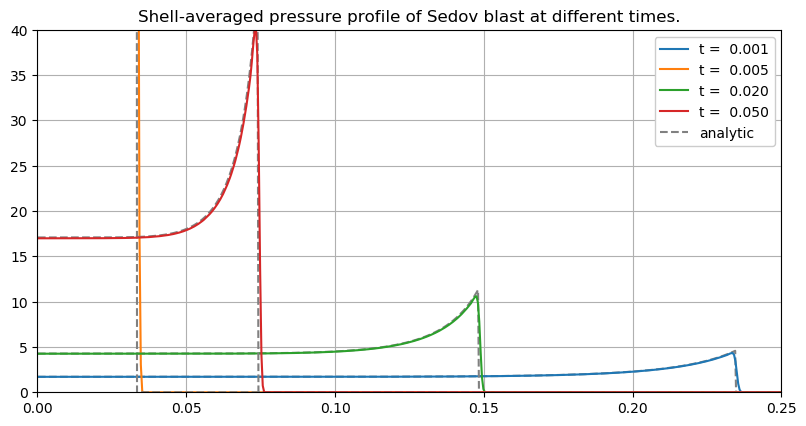

In [13]:
dpi = 100
fig = plt.figure(1,figsize=(1.5*640/dpi, 480/dpi), dpi=dpi)
plt.grid()
plt.xlim(0,0.25)
plt.ylim(0,40)
plt.title('Shell-averaged pressure profile of Sedov blast at different times.')

for ana,num,t in zip(analytics,numerics,[0.001,0.005,0.02,0.05]):
    plt.plot(ana.radius,ana.pres, label='_nolegend_', ls='--',color='gray')
    plt.plot(num.radius,num.pres, label='t = {:6.3f}'.format(t))

plt.plot([],[], label='analytic', ls='--',color='gray')
plt.legend().get_frame().set_alpha(1)